In [1]:
from PIL import Image
from ctypes import *
from typing import List
import cv2
import numpy as np
import vart
import os
import pathlib
import xir
import threading
import time
import sys
import argparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from PIL import Image
import numpy as np

100%|██████████| 109/109 [00:08<00:00, 12.39it/s]


---------------------------
Pre-processing 12 images...
Starting 1 threads...


Exception in thread Thread-11 (runDPU):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_109358/3490657972.py", line 356, in runDPU
IndexError: list assignment index out of range


---------------------------
Throughput=44.86 fps, total frames = 12, time=0.2675 seconds


12it [00:02,  4.04it/s]                      


IndexError: list index out of range

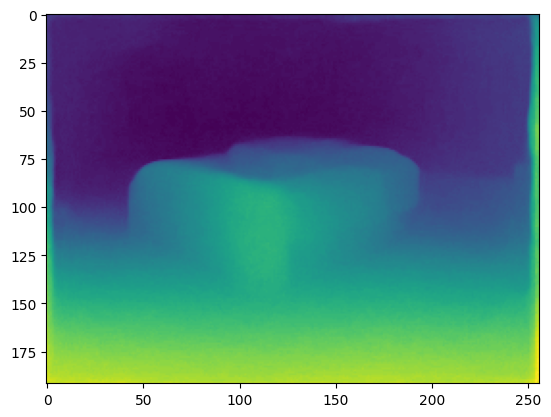

In [8]:
import torch
import cv2
import numpy as np

from scipy.io import loadmat

import torch.utils.data as data
import torch.nn.functional as F
from torchvision.transforms import Compose

from MiDaS.midas.midas_net import MidasNet
from MiDaS.midas.transforms import Resize, NormalizeImage, PrepareForNet
from glob import glob
from PIL import Image

girdiparca = 0
class NyuDepthV2(data.Dataset):
    def __init__(self, datapath, splitpath, split="test", transform=None,parca = girdiparca):

        self.__image_list = []
        self.__depth_list = []

        self.__transform = transform
        files = [(f'data/rgb_{i:05d}.png', f'data/depth_{i:05d}.npy') for i in range(parca*109,parca*109+109)]
        #files = glob('/home/ubuntu/Downloads/images/*')
        #files = [files[(i+2)%9] for i in range(9)]
        #files[0] = ('/home/ubuntu/Downloads/images/birr.png',f'data/depth_{0:05d}.npy')
        for id in files:
            i,d = id
            self.__image_list.append(np.array(Image.open(i))) 
            #self.__image_list.append(np.array(Image.open(i))[:,:,0]) 
            self.__depth_list.append(np.load(d))
        
        self.__length = len(self.__image_list)

    def __len__(self):
        return self.__length

    def __getitem__(self, index):
        # image
        image = self.__image_list[index]
        image = image / 255

        # depth
        depth = self.__depth_list[index]

        # mask; cf. project_depth_map.m in toolbox_nyu_depth_v2 (max depth = 10.0)
        mask = (depth > 0) & (depth < 10)

        # sample
        sample = {}
        sample["image"] = image
        sample["depth"] = depth
        sample["mask"] = mask

        # transforms
        if self.__transform is not None:
            sample = self.__transform(sample)

        return sample


class BadPixelMetric:
    def __init__(self, threshold=1.25, depth_cap=10):
        self.__threshold = threshold
        self.__depth_cap = depth_cap
        self.scaleshifts = []

    def compute_scale_and_shift(self, prediction, target, mask):
        # system matrix: A = [[a_00, a_01], [a_10, a_11]]
        a_00 = torch.sum(mask * prediction * prediction, (1, 2))
        a_01 = torch.sum(mask * prediction, (1, 2))
        a_11 = torch.sum(mask, (1, 2))

        # right hand side: b = [b_0, b_1]
        b_0 = torch.sum(mask * prediction * target, (1, 2))
        b_1 = torch.sum(mask * target, (1, 2))

        # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
        x_0 = torch.zeros_like(b_0)
        x_1 = torch.zeros_like(b_1)

        det = a_00 * a_11 - a_01 * a_01
        # A needs to be a positive definite matrix.
        valid = det > 0

        x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
        x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

        return x_0, x_1

    def __call__(self, prediction, target, mask):
        # transform predicted disparity to aligned depth
        target_disparity = torch.zeros_like(target)
        target_disparity[mask == 1] = 1.0 / target[mask == 1]

        scale, shift = self.compute_scale_and_shift(prediction, target_disparity, mask)
        self.scaleshifts.append((scale,shift)) #-shift/scale
        prediction_aligned = scale.view(-1, 1, 1) * prediction + shift.view(-1, 1, 1)

        disparity_cap = 1.0 / self.__depth_cap
        prediction_aligned[prediction_aligned < disparity_cap] = disparity_cap

        prediciton_depth = 1.0 / prediction_aligned

        # bad pixel
        err = torch.zeros_like(prediciton_depth, dtype=torch.float)
        d1 = torch.zeros_like(prediciton_depth, dtype=torch.bool)
        d2 = torch.zeros_like(prediciton_depth, dtype=torch.bool)
        d3 = torch.zeros_like(prediciton_depth, dtype=torch.bool)

        err[mask == 1] = torch.max(
            prediciton_depth[mask == 1] / target[mask == 1],
            target[mask == 1] / prediciton_depth[mask == 1],
        )

        d1[mask == 1] = (err[mask == 1] > self.__threshold)
        p1 = torch.sum(d1, (1, 2)) / torch.sum(mask, (1, 2))

        d2[mask == 1] = (err[mask == 1] > (self.__threshold)**2)
        p2 = torch.sum(d2, (1, 2)) / torch.sum(mask, (1, 2))

        d3[mask == 1] = (err[mask == 1] > (self.__threshold)**3)
        p3 = torch.sum(d3, (1, 2)) / torch.sum(mask, (1, 2))

        return 100 * torch.mean(p1), 100 * torch.mean(p2),100 * torch.mean(p3), prediciton_depth, target, err


class BadPixelLoss(torch.nn.Module):
    def __init__(self, threshold=1.25, depth_cap=10):
        self.__threshold = threshold
        self.__depth_cap = depth_cap

    def compute_scale_and_shift(self, prediction, target, mask):
        # system matrix: A = [[a_00, a_01], [a_10, a_11]]
        a_00 = torch.sum(mask * prediction * prediction, (1, 2))
        a_01 = torch.sum(mask * prediction, (1, 2))
        a_11 = torch.sum(mask, (1, 2))

        # right hand side: b = [b_0, b_1]
        b_0 = torch.sum(mask * prediction * target, (1, 2))
        b_1 = torch.sum(mask * target, (1, 2))

        # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
        x_0 = torch.zeros_like(b_0)
        x_1 = torch.zeros_like(b_1)

        det = a_00 * a_11 - a_01 * a_01
        # A needs to be a positive definite matrix.
        valid = det > 0

        x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
        x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

        return x_0, x_1

    def forward(self, prediction, target, mask):
        # transform predicted disparity to aligned depth
        target_disparity = torch.zeros_like(target)
        target_disparity[mask == 1] = 1.0 / target[mask == 1]

        scale, shift = self.compute_scale_and_shift(prediction, target_disparity, mask)
        prediction_aligned = scale.view(-1, 1, 1) * prediction + shift.view(-1, 1, 1)

        disparity_cap = 1.0 / self.__depth_cap
        prediction_aligned[prediction_aligned < disparity_cap] = disparity_cap

        prediciton_depth = 1.0 / prediction_aligned

        # bad pixel
        err = torch.zeros_like(prediciton_depth, dtype=torch.float)

        err[mask == 1] = 0.5*torch.square(prediciton_depth[mask == 1] / target[mask == 1])
        loss = torch.mean(err)
    
        return loss    
    
    
    
def validate(modelpath, nyu_data, nyu_split):
    # set torch options
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

    # select device
    device = torch.device("cpu")
    print("device: %s" % device)

    # load network
    #model = MidasNet(MODEL_PATH, non_negative=True)
    from smallmidas import MidasNet_small
    model = MidasNet_small(align_corners=False)
    parameters = torch.load(modelpath, 
                            map_location=torch.device('cpu'))

    if "optimizer" in parameters:
        parameters = parameters["model"]

    model.load_state_dict(parameters)
    
    
    model.to(device)
    model.eval()

    # get data
    transform = Compose(
        [
            Resize(
                256,
                256,
                resize_target=None,
                keep_aspect_ratio=True,
                ensure_multiple_of=32,
                resize_method="upper_bound",
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            PrepareForNet(),
        ]
    )

    ds = NyuDepthV2(NYU_DATA_PATH, NYU_SPLIT_PATH, split="train", transform=transform)
    dl = data.DataLoader(
        ds, batch_size=1, num_workers=1, shuffle=False, pin_memory=True
    )
    

    # validate
    #metric = BadPixelMetric()

    loss_sum = 0
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dl),total=654):
            #print(f"processing: {i + 1} / {len(ds)}")

            # to device
            for k, v in batch.items():
                batch[k] = v.to(device)

            # run model
            #batch['image'][...,[0,2]] = batch['image'][...,[2,0]] 
            prediction = model.forward(batch["image"])

            # resize prediction to match target
            prediction = F.interpolate(
                prediction.unsqueeze(1),
                size=batch["mask"].shape[1:],
                mode="bilinear",
                align_corners=False,
            )
            prediction = prediction.squeeze(1)

            loss,pd,t,e = metric(prediction, batch["depth"], batch["mask"])
            
            loss_sum += loss
            DEBUG = False
            if DEBUG:
                import matplotlib.pyplot as plt
                plt.imshow(pd.cpu().numpy().squeeze())
                plt.show()
                plt.imshow(t.cpu().numpy().squeeze())
                plt.show()
                plt.imshow(e.cpu().numpy().squeeze())
                plt.show()
                plt.imshow(np.swapaxes(np.swapaxes(batch["image"].cpu().numpy().squeeze(),2,0),0,1))
                plt.show()
            

    print(f"bad pixel: {loss_sum / len(ds):.2f}")



NYU_DATA_PATH = "/kaggle/input/matnyu/nyu_depth_v2_labeled.mat"

# download from http://horatio.cs.nyu.edu/mit/silberman/indoor_seg_sup/splits.mat
NYU_SPLIT_PATH = "splits.mat"

# download from https://drive.google.com/file/d/1nqW_Hwj86kslfsXR7EnXpEWdO2csz1cC
MODEL_PATH = "midas_v21_small_256.pt"

# validate
#validate(MODEL_PATH, NYU_DATA_PATH, NYU_SPLIT_PATH)

##############################

transform = Compose(
    [
        Resize(
            256,
            192,
            resize_target=None,
            keep_aspect_ratio=False,
            ensure_multiple_of=32,
            resize_method="upper_bound",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ]
)


divider='---------------------------'

def get_child_subgraph_dpu(graph: "Graph") -> List["Subgraph"]:
    assert graph is not None, "'graph' should not be None."
    root_subgraph = graph.get_root_subgraph()
    assert (root_subgraph is not None), "Failed to get root subgraph of input Graph object."
    if root_subgraph.is_leaf:
        return []
    child_subgraphs = root_subgraph.toposort_child_subgraph()
    assert child_subgraphs is not None and len(child_subgraphs) > 0
    return [
        cs
        for cs in child_subgraphs
        if cs.has_attr("device") and cs.get_attr("device").upper() == "DPU"
    ]

def runDPU(id,start,dpu,img):

    '''get tensor'''
    inputTensors = dpu.get_input_tensors()
    outputTensors = dpu.get_output_tensors()
    input_ndim = tuple(inputTensors[0].dims)
    output_ndim = tuple(outputTensors[0].dims)

    batchSize = input_ndim[0]
    n_of_images = len(img)
    count = 0
    write_index = start
    while count < n_of_images:
        if (count+batchSize<=n_of_images):
            runSize = batchSize
        else:
            runSize=n_of_images-count

        '''prepare batch input/output '''
        outputData = []
        inputData = []
        inputData = [np.empty(input_ndim, dtype=np.float32, order="C")]
        outputData = [np.empty(output_ndim, dtype=np.float32, order="C")]

        '''init input image to input buffer '''
        for j in range(runSize):
            imageRun = inputData[0]
            imageRun[j, ...] = img[(count + j) % n_of_images].reshape(input_ndim[1:])

        '''run with batch '''
        job_id = dpu.execute_async(inputData,outputData)
        dpu.wait(job_id)

        '''store output vectors '''
        for j in range(runSize):
            out_q[write_index] = outputData[0][j]
            write_index += 1
        count = count + runSize


def app(image_dir,threads,model):

    listimage=os.listdir(image_dir)
    runTotal = len(listimage)

    global out_q
    out_q = [None] * runTotal

    g = xir.Graph.deserialize(model)
    subgraphs = get_child_subgraph_dpu(g)
    all_dpu_runners = []
    for i in range(threads):
        all_dpu_runners.append(vart.Runner.create_runner(subgraphs[0], "run"))

    ''' preprocess images '''
    print('Pre-processing',runTotal,'images...')
        

    print('Starting',threads,'threads...')
    threadAll = []
    start=0
    for i in range(threads):
        if (i==threads-1):
            end = len(img)
        else:
            end = start+(len(img)//threads)
        in_q = img[start:end]
        t1 = threading.Thread(target=runDPU, args=(i,start,all_dpu_runners[i], in_q))
        threadAll.append(t1)
        start=end

    time1 = time.time()
    for x in threadAll:
        x.start()
    for x in threadAll:
        x.join()
    time2 = time.time()
    timetotal = time2 - time1

    fps = float(runTotal / timetotal)
    print(divider)
    print("Throughput=%.2f fps, total frames = %.0f, time=%.4f seconds" %(fps, runTotal, timetotal))

    #abslosses = []
    #for i in range(len(out_q)):
        #postprocess_and_save(out_q[i], save_path='output_image.png')
        #ground_truth, _ = listimage[i].split('_',1)
        #l = np.mean(np.abs(out_q[i]-ground_truth))
        #abslosses.append(l)

    #print('Loss mean: %.4f' %(np.array(abslosses).mean()))
    #print(divider)

    return timetotal

lossgirdi1 = []
lossgirdi2 = []
lossgirdi3 = []
sure = 0
for girdiparca in range(4,5):

    ds = NyuDepthV2(NYU_DATA_PATH, NYU_SPLIT_PATH, split="train", transform=transform, parca=girdiparca)
    dl = data.DataLoader(
        ds, batch_size=1, num_workers=1, shuffle=False, pin_memory=True
    )

    # validate
    metric = BadPixelMetric()

    loss_sum1 = 0
    loss_sum2 = 0
    loss_sum3 = 0
    import matplotlib.pyplot as plt
    from tqdm import tqdm

    img = []
    for i, batch in tqdm(enumerate(dl),total=109):
        img.append(batch['image'].permute(0,2,3,1))


    image_dir='images'
    threads=1
    model='/home/ubuntu/Downloads/target_kv260/fcn8/model/fcn8.xmodel'

    print(divider)
    ttotal = app(image_dir,threads,model)
    sure += ttotal
    plt.imshow(out_q[0])
    
    for i, batch in tqdm(enumerate(dl),total=9):

        # run model
        #batch['image'][...,[0,2]] = batch['image'][...,[2,0]] 
        prediction = out_q[i]

        # resize prediction to match target
        prediction = F.interpolate(
            torch.tensor(prediction).unsqueeze(0).unsqueeze(1),
            size=batch["mask"].shape[1:],
            mode="bilinear",
            align_corners=False,
        )
        prediction = prediction.squeeze(1)

        loss1,loss2, loss3,pd,t,e = metric(prediction, batch["depth"], batch["mask"])
        loss_sum1 += loss1
        loss_sum2 += loss2
        loss_sum3 += loss3
        
    lossgirdi1.append(loss_sum1 / len(ds))
    lossgirdi2.append(loss_sum2 / len(ds))
    lossgirdi3.append(loss_sum3 / len(ds))
    print(f"bad pixel1: {loss_sum1 / len(ds):.2f}")
    print(f"bad pixel2: {loss_sum2 / len(ds):.2f}")
    print(f"bad pixel:3 {loss_sum3 / len(ds):.2f}")

print("Average bad pixel: ", sum(lossgirdi1)/len(lossgirdi1))
print("Average bad pixel: ", sum(lossgirdi2)/len(lossgirdi2))
print("Average bad pixel: ", sum(lossgirdi3)/len(lossgirdi3))
print("Average fps: ", 654/sure)

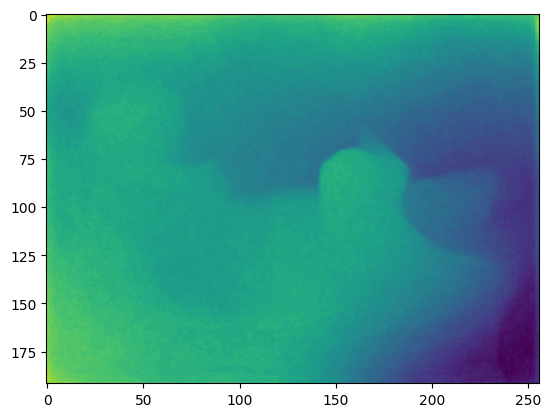

In [45]:
plt.imshow(out_q[8])

In [34]:
next(it)['image'].shape

StopIteration: 

In [9]:
plt.imsave('/home/ubuntu/Downloads/save/2.png', out_q[1], cmap='viridis')

In [99]:
import scipy.ndimage

In [ ]:
zoom_factors = (0.4,0.4)


In [65]:
targets = [np.load(f'/home/ubuntu/Downloads/data/depth_{i:05d}.npy') for i in range(436,545)]

In [66]:
targets[0].max()

6.11

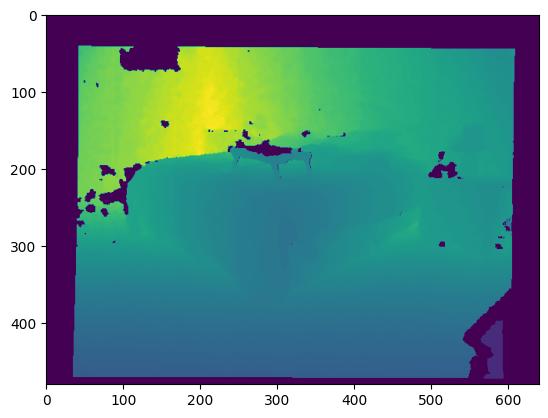

In [68]:
plt.imshow(targets[0])

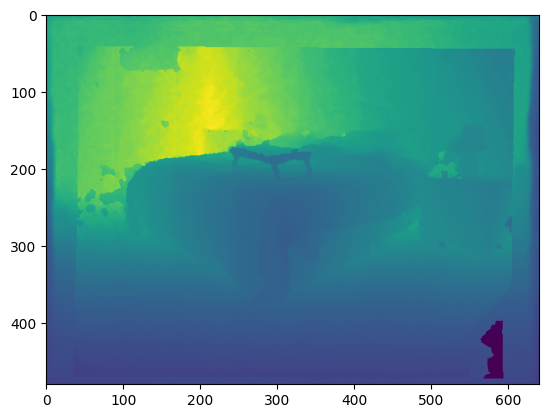

In [70]:
plt.imshow(targets[0])

In [75]:
t[0].min()

704.0

In [115]:
tt = [t[i][50:-50,50:-50] for i in range(109)]

In [90]:
oref = [out_q[i][20:-20,20:-20] for i in range(109)]

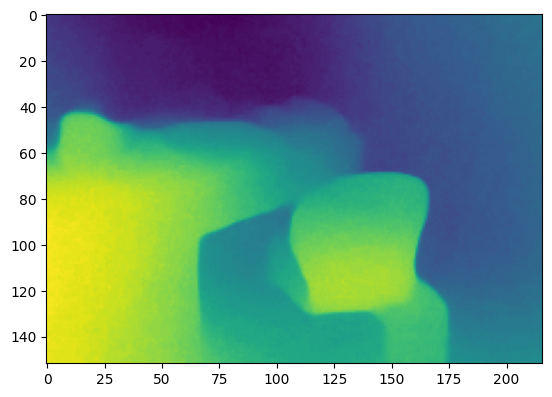

In [123]:
plt.imshow(oref[2])

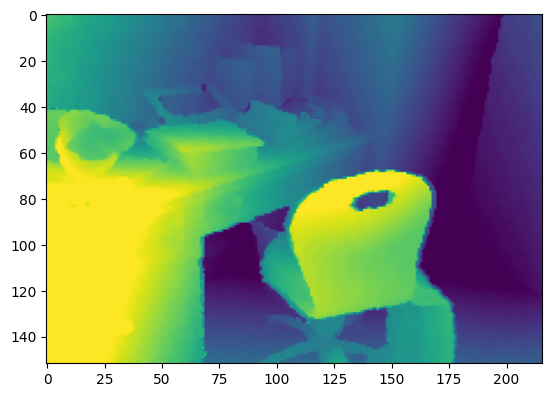

In [122]:
plt.imshow(tt[2])

In [116]:
for i in range(109):
    ttt= F.interpolate(
            torch.tensor(tt[i]).unsqueeze(0).unsqueeze(0),
            size=(152, 216),
            mode="bilinear",
            align_corners=False,
        ).numpy().squeeze()
    tt[i] = ttt

In [105]:
zoom_factors = (0.4, 0.4)
tt = [scipy.ndimage.zoom(tt[i], zoom_factors, order=1) for i in range(109)]

RuntimeError: data type not supported

In [35]:
ss = metric.scaleshifts

In [69]:
for i in range(109):
    scale, shift = ss[i][0].item(), ss[i][1].item()
    prediction = out_q[i]

    # resize prediction to match target
    prediction = F.interpolate(
        torch.tensor(prediction).unsqueeze(0).unsqueeze(1),
        size=batch["mask"].shape[1:],
        mode="bilinear",
        align_corners=False,
    )
    prediction= prediction.squeeze()
    prediction_aligned = prediction*scale + shift
    prediction_aligned[prediction_aligned < 0.1] = 0.1
    prediciton_depth = 1.0 / prediction_aligned
    mask = targets[i]==0
    targets[i][mask] = prediciton_depth[mask]

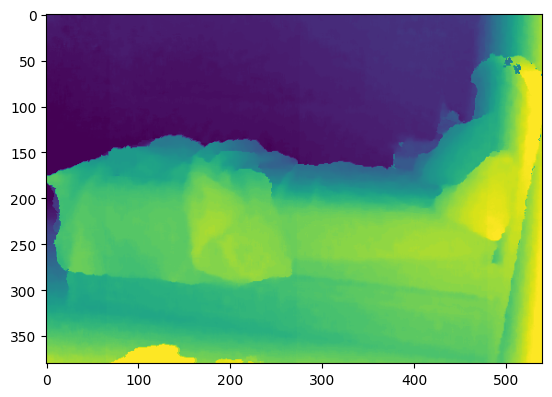

In [98]:
plt.imshow(t[1][50:-50,50:-50])

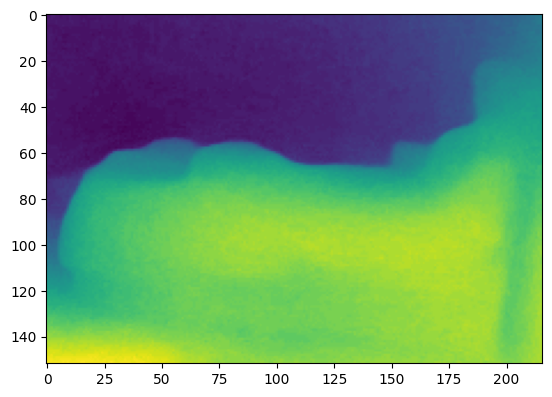

In [97]:
plt.imshow(oref[1])

In [107]:
oref[0].shape

(152, 216)

In [92]:
t = [np.clip((1/targets[i]-ss[i][1].item())/ss[i][0].item() , oref[i].min(), oref[i].max()) for i in range(109)]

In [53]:
i = 0
a = np.clip((targets[i]-ss[i][1].item())/ss[i][0].item() , out_q[i].min(), out_q[i].max()) 

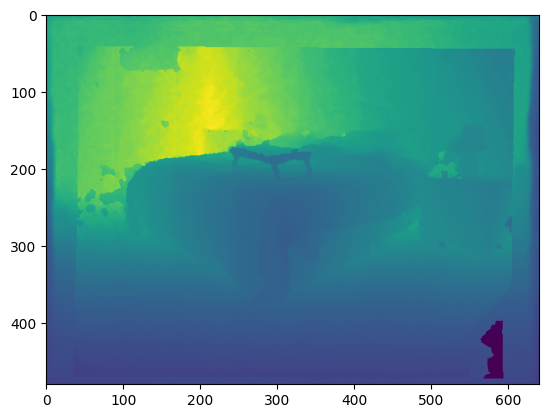

In [56]:
plt.imshow(targets[0])

In [60]:
targets[0].min()

0.755

In [59]:
targets[0][410][580]

0.781

In [132]:
from PIL import Image

def process_image(index = 0, clip_pixels=50, resize_factor=0.4):
    input_path, output_path = f'/home/ubuntu/Downloads/data/rgb_{(index+436):05d}.png', f'/home/ubuntu/Downloads/qualitative/nyu/rgb_{index}.png'
    # Open the image
    image = Image.open(input_path)

    # Clip pixels from each edge
    width, height = image.size
    clipped_image = image.crop((clip_pixels, clip_pixels, width - clip_pixels, height - clip_pixels))

    # Resize the image
    new_width = int(clipped_image.width * resize_factor)
    new_height = int(clipped_image.height * resize_factor)
    resized_image = clipped_image.resize((new_width, new_height), Image.BILINEAR)

    # Save the resized image
    resized_image.save(output_path)


In [134]:
for i in range(109):
    process_image(i)

In [14]:
class TargetDisp:
    def __init__(self, threshold=1.25, depth_cap=10):
        self.__threshold = threshold
        self.__depth_cap = depth_cap

    def __call__(self, target):
        # transform predicted disparity to aligned depth
        target_disparity = torch.clip(target,0.01,10)
        target_disparity = 1.0 / target_disparity
        return target_disparity
        

In [47]:
def minmax_normalize_and_save(array ,type='depth', index=0):
    # Min-max normalization
    min_val = np.min(array)
    max_val = np.max(array)
    normalized_array = (array - min_val) / (max_val - min_val)
    output_filename = f"/home/ubuntu/Downloads/qualitative/nyu/{type}_{index}.png"
    # Save normalized array as PNG using Matplotlib
    plt.imsave(output_filename, normalized_array, cmap='viridis')
    #print(f"Normalized array saved as {output_filename}")

In [48]:
#tdisp =  TargetDisp()
for i in range(12):
    minmax_normalize_and_save(out_q[i] ,type='rand', index=i)
    #minmax_normalize_and_save(oref[i] ,type='pred', index=i)
    #minmax_normalize_and_save(tt[i] ,type='gt', index=i)
    #loss1,loss2, loss3,pd,t,e = metric(prediction, batch["depth"], batch["mask"])

In [117]:
#out_q[0].shape
prediction.shape,batch['depth'].shape

(torch.Size([1, 480, 640]), torch.Size([1, 480, 640]))

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Activate interactive mode for matplotlib
plt.ion()

cap = cv2.VideoCapture(0)  # Use the default camera (change the index if you have multiple cameras)

# Create a figure for displaying the image
fig, ax = plt.subplots()
img_plot = ax.imshow(np.zeros((480, 640, 3), dtype=np.uint8))
plt.title('Input Image')
plt.axis('off')

while True:
    ret, f = cap.read()

    if f is not None:
        #fr = cv2.resize(f, (64, 64))
        frame = f.astype(np.float32) / 256

        # Update the image data
        img_plot.set_data(frame)

        # Refresh the display
        fig.canvas.draw()

        # Pause for a short duration (adjust as needed)
        plt.pause(1)

In [2]:
def postprocess_and_save(output_tensor, save_path='output_image.png'):
    # Normalize the output tensor between 0 and 255
    normalized_output = ((output_tensor - output_tensor.min()) / (output_tensor.max() - output_tensor.min())) * 255
    normalized_output = normalized_output.astype(np.uint8) # Convert to byte tensor for image saving

    # Convert the byte tensor to a numpy array
    np_output = normalized_output

    # Convert the numpy array to a PIL image
    pil_image = Image.fromarray(np_output)#.transpose((1, 2, 0)))

    # Save the PIL image as a PNG
    pil_image.save(save_path)

# Example usage:
# Assuming `output_tensor` is your output tensor from the neural network
# postprocess_and_save(output_tensor, 'output_image.png')

In [52]:
import os
from PIL import Image


output_dir = '/home/ubuntu/Downloads/imagess'
input_dir = '/home/ubuntu/Downloads/images'
# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define the new size
new_size = (256, 192)  # (width, height)

# Process each image in the input directory
for i,filename in enumerate(glob('/home/ubuntu/Downloads/images/*')):
    with Image.open(filename) as img:
        # Resize image
        resized_img = img.resize(new_size, Image.ANTIALIAS)
        
        # Save resized image to the output directory
        resized_img.save(os.path.join(output_dir, f'{i}.png'))
        
        print(f"Resized and saved {filename}")


print("Image resizing completed.")

Resized and saved /home/ubuntu/Downloads/images/birr.png
Resized and saved /home/ubuntu/Downloads/images/3586506567_1f40ee54fb_z.jpg
Resized and saved /home/ubuntu/Downloads/images/4844332239_40e9dc490d_z.jpg
Resized and saved /home/ubuntu/Downloads/images/9794636944_714b073d8d_z.jpg
Resized and saved /home/ubuntu/Downloads/images/9688289839_ac5a242090_z.jpg
Resized and saved /home/ubuntu/Downloads/images/3268020209_fbccd01dcc_z.jpg
Resized and saved /home/ubuntu/Downloads/images/8665542458_2d5ba01796_z.jpg
Resized and saved /home/ubuntu/Downloads/images/8323609125_f9b76fab22_z.jpg
Resized and saved /home/ubuntu/Downloads/images/521761554_e3bf829f91_z.jpg
Resized and saved /home/ubuntu/Downloads/images/8500821692_151a173793_z.jpg
Resized and saved /home/ubuntu/Downloads/images/7212153504_c8ac1788a3_z.jpg
Resized and saved /home/ubuntu/Downloads/images/3209636927_6e1e51b548_z.jpg
Image resizing completed.


In [3]:
def preprocess_fn(image):
    # Resize to (256, 256)
    print(image)
    resized_image = np.array(Image.open(image).resize((256, 256)))
    
    # Convert to tensor
    tensor_image = np.transpose(resized_image, (2, 0, 1))  # Convert to channels-first format
    tensor_image = tensor_image / 255.0  # Normalize to [0, 1]
    tensor_image = (tensor_image - np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))) / np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))  # Normalize
    
    tensor_image = np.transpose(tensor_image, (1, 2, 0))  # Convert to channels-first format
    return tensor_image

In [13]:
divider='---------------------------'

def get_child_subgraph_dpu(graph: "Graph") -> List["Subgraph"]:
    assert graph is not None, "'graph' should not be None."
    root_subgraph = graph.get_root_subgraph()
    assert (root_subgraph is not None), "Failed to get root subgraph of input Graph object."
    if root_subgraph.is_leaf:
        return []
    child_subgraphs = root_subgraph.toposort_child_subgraph()
    assert child_subgraphs is not None and len(child_subgraphs) > 0
    return [
        cs
        for cs in child_subgraphs
        if cs.has_attr("device") and cs.get_attr("device").upper() == "DPU"
    ]

In [5]:
def runDPU(id,start,dpu,img):

    '''get tensor'''
    inputTensors = dpu.get_input_tensors()
    outputTensors = dpu.get_output_tensors()
    input_ndim = tuple(inputTensors[0].dims)
    output_ndim = tuple(outputTensors[0].dims)

    batchSize = input_ndim[0]
    n_of_images = len(img)
    count = 0
    write_index = start
    while count < n_of_images:
        if (count+batchSize<=n_of_images):
            runSize = batchSize
        else:
            runSize=n_of_images-count

        '''prepare batch input/output '''
        outputData = []
        inputData = []
        inputData = [np.empty(input_ndim, dtype=np.float32, order="C")]
        outputData = [np.empty(output_ndim, dtype=np.float32, order="C")]

        '''init input image to input buffer '''
        for j in range(runSize):
            imageRun = inputData[0]
            imageRun[j, ...] = img[(count + j) % n_of_images].reshape(input_ndim[1:])

        '''run with batch '''
        job_id = dpu.execute_async(inputData,outputData)
        dpu.wait(job_id)

        '''store output vectors '''
        for j in range(runSize):
            out_q[write_index] = outputData[0][j]
            write_index += 1
        count = count + runSize


def app(image_dir,threads,model):

    listimage=os.listdir(image_dir)
    runTotal = len(listimage)

    global out_q
    out_q = [None] * runTotal

    g = xir.Graph.deserialize(model)
    subgraphs = get_child_subgraph_dpu(g)
    all_dpu_runners = []
    for i in range(threads):
        all_dpu_runners.append(vart.Runner.create_runner(subgraphs[0], "run"))

    ''' preprocess images '''
    print('Pre-processing',runTotal,'images...')
    img = []
    for i in range(runTotal):
        path = os.path.join(image_dir,listimage[i])
        img.append(preprocess_fn(path))

    '''run threads '''
    print('Starting',threads,'threads...')
    threadAll = []
    start=0
    for i in range(threads):
        if (i==threads-1):
            end = len(img)
        else:
            end = start+(len(img)//threads)
        in_q = img[start:end]
        t1 = threading.Thread(target=runDPU, args=(i,start,all_dpu_runners[i], in_q))
        threadAll.append(t1)
        start=end

    time1 = time.time()
    for x in threadAll:
        x.start()
    for x in threadAll:
        x.join()
    time2 = time.time()
    timetotal = time2 - time1

    fps = float(runTotal / timetotal)
    print(divider)
    print("Throughput=%.2f fps, total frames = %.0f, time=%.4f seconds" %(fps, runTotal, timetotal))

    #abslosses = []
    #for i in range(len(out_q)):
        #postprocess_and_save(out_q[i], save_path='output_image.png')
        #ground_truth, _ = listimage[i].split('_',1)
        #l = np.mean(np.abs(out_q[i]-ground_truth))
        #abslosses.append(l)

    #print('Loss mean: %.4f' %(np.array(abslosses).mean()))
    print(divider)

    return

In [9]:
image_dir='images'
threads=1
model='/home/ubuntu/Downloads/target_kv260/fcn8/model/fcn8.xmodel'

print(divider)

app(image_dir,threads,model)

---------------------------
Pre-processing 4 images...
images/birr copy.png
images/birr.png
images/birr copy 2.png
images/birr copy 3.png
Starting 1 threads...
---------------------------
Throughput=38.53 fps, total frames = 4, time=0.1038 seconds
---------------------------
